# About Donorschoose.org


DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.



Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: 
* How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
* How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
* How to focus volunteer time on the applications that need the most assistance</li>
   


The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

## Understand the DonorsChoose Data Set's Attributes

There are two files:   1.train_data.csv(consists 17 features)

                2.resources.csv(consists 4 features)

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### importing all necessary modules

In [1]:
#import all necessary modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors



from tqdm import tqdm
import os

from collections import Counter

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## 1. Reading Data

In [2]:
#load two datafiles into the dataframe
project_data = pd.read_csv('train_data.csv')
resources_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('*'*80)

print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
********************************************************************************
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
#dataframe
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [5]:
#dataframe
resources_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [6]:
#print number of datapoints and columns in resources_data
print('number of datapoints in resources_data:',resources_data.shape)
print("*"*60)
print('total features in resources_data:', resources_data.columns)

number of datapoints in resources_data: (1541272, 4)
************************************************************
total features in resources_data: Index(['id', 'description', 'quantity', 'price'], dtype='object')


**observation:**
* in project data we have 109248 datapoints(rows) and 17 features (columns).
* in resources_data we have 1541272 datapoints and  4 features(columns)

**'Project_is_approved'** Attribute:
* in the project_proposal_data' dataframe we have  'project is approved'  Attribute, it consists with 2 values that are [1]Number of projects approved and [0] number of projects not approved.

# 2. text preprocessing ( text data& categorical data)

**remove and replace  unwanted symbols, special charecters and words**

In [7]:
catogories = list(project_data['project_subject_categories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [8]:
project_data['clean_proj_categories'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_categories'], axis=1, inplace=True) #remove that previous subject_catogery attribute.

### 2.2 project_grade_category

In [9]:
catogories = list(project_data['project_grade_category'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        j = j.replace(' ','_') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('-','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [10]:
project_data['clean_proj_grade'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_grade_category'], axis=1, inplace=True) #remove that previous grade_catogery attribute.

### 2.3  project_subject_subcategories

In [11]:
catogories = list(project_data['project_subject_subcategories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
lst = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    lst.append(temp.strip())
#lst is list with all cleaned subcategories.

In [12]:
project_data['clean_proj_subcategories'] = lst    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True) #remove that previous subject_subcatogery attribute.

## 2.4 Text Preprocessing
###  Project Essay's

there are we have 4 essays's:
   1.  project_essay_1 
   2.  project_essay_2
   3.  project_essay_3 
   4.  project_essay_4
* so we have to  merge(combilne) 4 essays into one single essay.

In [13]:
# merge all essay columns into single essay columns 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [14]:
#remove that previous project_essay_1,2,3 and 4
project_data.drop(["project_essay_1"], axis=1, inplace=True) 
project_data.drop(["project_essay_2"], axis=1, inplace=True) 
project_data.drop(["project_essay_3"], axis=1, inplace=True) 
project_data.drop(["project_essay_4"], axis=1, inplace=True) 

In [15]:
# to observe the random esssay text data
print(project_data['essay'].values[102])

Hello!, thank you for wanting to learn more about my class! My students are Deaf and Hard-of-Hearing. The ages range from 6-8 years old. They don't have a lot of the life experiences as other students do. Almost all of my class qualifies for free lunch. Some of them ride the bus for over an hour a day (one way) to get to school. I would like to make learning fun and interactive.\r\n\r\nThey don't have access to language as other students. I want my students to become engaged in their learning and be able to interact with it. I can show them pictures in a book but then I have to put the book down so I can sign the story. So they lose the visual. It isn't possible to sign and hold a book at the same time.\r\n\r\nMy classroom is special because my students require a lot of visual aids and pictures.  I would love to show them a video of a whale or show them pictures about what we are learning.This technology would benefit my students so much. They would be able to see the text or book that

**observation**
* In the above essay feature  there are lot of unnecessary  special charecters and some other  words so we have to clean text data

In [16]:
# expand contractions

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
#english stopwords
import nltk
d = nltk.corpus.stopwords.words('english')
print(set(d))
print(len(d))


{"wasn't", 'after', 'once', 'he', 'them', 'doing', 'have', 'below', "she's", 'why', 'before', 'if', 'himself', 'with', "you're", 'each', 'all', 'll', 'didn', 'am', 'not', 'themselves', 'hadn', 'did', 'o', 'doesn', 'haven', "mustn't", 'when', 'from', 'or', 'had', 'again', 'should', 'my', "don't", 'y', 'having', 'same', 'these', "doesn't", 'no', 'his', 'herself', 'our', 'shouldn', "you'll", 'over', 't', 'you', "isn't", 'was', 've', 'hasn', 'between', 'myself', 'those', 'other', 'ours', 'until', 'few', "you've", 'we', 'on', "couldn't", 'd', 'does', 'some', 'above', 'hers', 'because', 'more', 'are', 'only', 'm', "that'll", 'so', 'wouldn', 'weren', 'any', "didn't", 'a', 'theirs', 'by', 'mightn', "wouldn't", 'for', 'off', "it's", 'but', 'out', 'don', 'who', "hadn't", 'that', 'at', "you'd", 'both', 'shan', 'own', "won't", "shouldn't", 'in', 'how', 'too', 'whom', 'will', 'then', 'to', "haven't", 'yours', 'about', 'won', 'where', 'him', 'there', 'itself', 'has', "shan't", 'her', 'while', 'could

#### note: we should remove some  words('no', 'nor', 'not') from stop words 

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 2.3.1 text preprocessing project_essay

In [19]:
#replace & remove some unneccesary words in text

from tqdm import tqdm
preproccessed_essay_text = []
# tqdm is for printing the status bar
for sent in tqdm(project_data['essay'].values):    #all text data in essay feature 
    s = decontracted(sent)                  #function calling for expand contraction words
    s = s.replace('\\r', ' ')                   #replacing \\r with space
    s = s.replace('\\"', ' ')                   #replacing \\"', with space
    s = s.replace('\\n', ' ')                   #replacing \\n with space
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_essay_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:57<00:00, 1884.59it/s]


In [20]:
project_data['preproccessed_essay_text'] = preproccessed_essay_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['essay'], axis=1, inplace=True) #remove that previous essay attribute.

### 3.2.2 Text preprocessing project_Title

In [21]:
# to observe the some random title text data
print(project_data['project_title'].values[12])
print("*"*40)
print(project_data['project_title'].values[1640])
print("*"*40)

Building Life Science Experiences
****************************************
Scientists at Work Need Materials
****************************************


#### text preprocessing project_title

In [22]:
from tqdm import tqdm
preproccessed_title_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):    #all text data in essay feature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_title_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:03<00:00, 33836.61it/s]


In [23]:
project_data['preproccessed_title_text'] = preproccessed_title_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_title'], axis=1, inplace=True) #remove that previous project title attribute.

#### Text preprocessing project_resource_summary

In [24]:
from tqdm import tqdm
preproccessed_resource_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_resource_summary'].values):    #all text data in project_resource_summaryfeature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_resource_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:05<00:00, 18524.16it/s]


In [25]:
project_data['preproccessed_prjct_resource_summary'] = preproccessed_resource_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_resource_summary'], axis=1, inplace=True) #remove that previous resource_text attribute.

## 2.3.4 dataframe after text preprocessed features

In [26]:
#print top 4 data points  after text preprocessed features
project_data.head(4)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,4,1,Literacy_Language Math_Science,Grades_PreK_2,Literacy Mathematics,i work at a unique school filled with both esl...,techie kindergarteners,my students need to engage in reading and math...


## 2.4 Join two dataframe(project_proposal_data and resources_data) based on ID

In [27]:
#to get price of the project
resources_data.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [28]:
#https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
#from resources data  coulumns group by id and sum values of two columns
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(3)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4


In [29]:
#join(merge) two data frames based on id
project_data = pd.merge(project_data, price_data, on='id', how='left')  #how=lef if any remaining data present in any df that will be merge with dataframe


In [30]:
#shape of the final merged dataframe
project_data.shape

(109248, 16)

we have 109248 datapoints and 16 features

## print final data frame

In [31]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...,516.85,22


## 2.5.1 (identify) select the class lable 

according to the above dataframe 
**'Project_is_approved'** Attribute:
* in the project_data' dataframe we have  'project is approved'  Attribute, it consists with 2 values that are [1]Number of projects approved and [0] number of projects not approved.

In [32]:
#y is class label
y = project_data['project_is_approved'].values       #storing all project_is approved attribute values in y variable
project_data.drop(['project_is_approved'], axis=1, inplace=True)    #eliminate the project_is_approved attribute from dataframe


# 2.6 Splitting data

### split data into train, cross validation and test data

In [33]:
# splitting into train, crossvalidation and test data
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(project_data, y, test_size=0.33, stratify=y)  # split 33% data in test data and  67% in train data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)  #split train data into train and cross_valiadation

our total dataset splitted into train data, cross validation data and test data.

In [34]:
#print shape of splitted data
print("data before feature vectorizing:")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

data before feature vectorizing:
(49041, 15) (49041,)
(24155, 15) (24155,)
(36052, 15) (36052,)


**observation**
* there are 22445 datapoints in train data.
* 11055 datapoints in cross validation data.
* 16500 datapoints in test data.

# 2.7 Creating Data Matrix

# 2.8 feature vectorization (BOW)

## 2.8.1 converting the preproccessed_essay_text to vectors(bag of words)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #select maximum vectorized features = 5000
vectorizer1.fit(X_train['preproccessed_essay_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_essay_bow = vectorizer1.transform(X_train['preproccessed_essay_text'].values)
X_cv_essay_bow = vectorizer1.transform(X_cv['preproccessed_essay_text'].values)
X_test_essay_bow = vectorizer1.transform(X_test['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


* after BOW vecterization we have X_train data 49041 data points with 5000 features
* in x_cv 24155 datapoints, 5000features
* in x_test 36052 datapoints, and 5000 features

## 2.8.2 converting the preproccessed_title_text to vectors(bag of words)

In [36]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #select maximum vectorized features = 5000
vectorizer1.fit(X_train['preproccessed_title_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_title_bow = vectorizer1.transform(X_train['preproccessed_title_text'].values)
X_cv_title_bow = vectorizer1.transform(X_cv['preproccessed_title_text'].values)
X_test_title_bow = vectorizer1.transform(X_test['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)


************************************************************
After vectorizations:
(49041, 4729) (49041,)
(24155, 4729) (24155,)
(36052, 4729) (36052,)


# 2.9 feature vectorization (TFIDF)

## 2.9.1 converting the preproccessed_essay_text to vectors(TFIDF)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)#select maximum vectorized features = 5000
vectorizer2.fit(X_train['preproccessed_essay_text'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_essay_tfidf = vectorizer2.transform(X_train['preproccessed_essay_text'].values)
X_cv_essay_tfidf = vectorizer2.transform(X_cv['preproccessed_essay_text'].values)
X_test_essay_tfidf = vectorizer2.transform(X_test['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


## 2.9.2 converting the preproccessed_title_text to vectors(TFIDF)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2_1 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)#select maximum vectorized features = 5000
vectorizer2_1.fit(X_train['preproccessed_title_text'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_title_tfidf = vectorizer2_1.transform(X_train['preproccessed_title_text'].values)
X_cv_title_tfidf = vectorizer2_1.transform(X_cv['preproccessed_title_text'].values)
X_test_title_tfidf = vectorizer2_1.transform(X_test['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 4729) (49041,)
(24155, 4729) (24155,)
(36052, 4729) (36052,)


# 2.10 feature vectorization (AVGW2V)

## 1. Training W2V model

In [39]:
#import word2vec 
from gensim.models import Word2Vec   #to make own w2vec model
from gensim.models import KeyedVectors   #w2v model by googlenews-300.bin
from tqdm import tqdm
import numpy as np

#### 1.1 Preparing list of list with sentences for model

In [40]:
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_essay_text'].values:  #for ecah sentence(text) in  essay text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

### 1.2 train Word2Vec on train data(list of sentences)

In [41]:
# train w2v model on  list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)
#list of sentence [['w1'],['w2']....] in train essay data, min_count = 6 if word  atleast 6times occure then it will be consider
#size = 50 w-->vec dimensions, workers=4  multicore of computer(laptop)

In [42]:
w2v_words = list(w2v_model.wv.vocab)     #model trained vocubulary words
print("all words occured minimum 4 times ",len(w2v_words))
print("sample_w2v_ words ", w2v_words[0:60])   #print 40 words

all words occured minimum 4 times  15816
sample_w2v_ words  ['our', 'school', 'is', 'in', 'the', 'center', 'of', 'start', 'up', 'companies', 'but', 'that', 'does', 'not', 'mean', 'my', 'students', 'have', 'equal', 'access', 'to', 'technology', 'i', 'would', 'like', 'provide', 'those', 'opportunities', 'classroom', 'are', 'full', 'with', 'curiosity', 'and', 'ideas', 'they', 'never', 'give', 'at', 'any', 'task', 'learn', 'through', 'trial', 'error', 'eager', 'collaborate', 'share', 'their', 'creativity', 'others', 'afraid', 'failing', 'because', 'from', 'it', 'every', 'time', 'make', 'better']


total words 11639 wich are occured atleast 4 times in model trained vocubulary words

## 2.10.1 converting the preproccessed_essay_text to vectors(AVGW2V)

##  I. Converting Train data  essay text to AVGW2V

In [43]:
# average Word2Vec
# compute average word2vec for each datapoint in essay_train data.
X_train_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_train): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_essay_avgw2v.append(sent_vec)
X_train_essay_avgw2v = np.array(X_train_essay_avgw2v)  #converting all essay word2vec words into array
print(X_train_essay_avgw2v.shape)
print(X_train_essay_avgw2v[2])

100%|██████████| 49041/49041 [04:44<00:00, 172.43it/s]


(49041, 50)
[ 0.14246934  0.35002982  0.39653983  0.29422195 -0.42143874 -0.11236015
 -0.76730156  0.04180802  0.53142608  0.08571169 -0.77380864  0.0844195
 -0.8774237  -0.43270643  0.1613448  -0.4032291   0.76967734 -0.60020619
  0.08379465  0.89351141 -2.07660986 -0.09758392 -0.1916027  -0.79707207
 -1.04701656  1.11306257 -0.20031116 -0.75800182 -0.19369787  0.18833775
 -0.52054335 -0.06419371 -0.07472566 -0.45852336  0.77443597 -0.39648289
 -0.46710135 -0.5157097  -1.16337523 -0.18011301 -0.71509301  0.11507637
 -0.51290314 -0.05742121 -0.21933045 -0.23079731 -0.8442362  -0.52313392
  0.36699553  1.25564353]


## II. Converting Cross_Validation  essay data text to AVGW2V

In [44]:
i = 0
list_of_sentance_cv=[]  #empty list 
for sentance in X_cv['preproccessed_essay_text'].values:  #for ecah sentence(text)  in  essay text cv data
    list_of_sentance_cv.append(sentance.split())   #append in list (list of lists with   sentences)

In [45]:
# average Word2Vec
# compute average word2vec for each datapoint in cv data.
X_cv_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_cv): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_essay_avgw2v.append(sent_vec)
X_cv_essay_avgw2v = np.array(X_cv_essay_avgw2v)  #converting all essay word2vec words into array
print(X_cv_essay_avgw2v.shape)
print(X_cv_essay_avgw2v[2])

100%|██████████| 24155/24155 [02:21<00:00, 170.35it/s]

(24155, 50)
[-0.07509221  0.14272157  0.16883492  0.4581369  -0.28152692 -0.16628253
 -0.70819989  0.25769451  0.36495831 -0.00721121 -0.92949849  0.15444383
 -0.98808614  0.14645937  0.27856869 -0.12826037  1.2167744   0.21857042
 -0.48531037  0.43896257 -1.01762251 -0.17363333  0.22994688 -0.65391219
 -1.02421326  0.90686874 -0.76917322 -0.43994543 -0.05822401 -0.55244537
 -0.36456648 -0.33428091  0.06189679 -0.37545689  0.55584202 -0.40656354
 -0.92453987 -0.86189092 -0.44863751  0.07818874 -0.61524135  0.21466763
 -0.34163546 -0.34320012 -0.20152266 -0.29193434 -0.42411521 -0.32292261
  0.4255411   0.96381267]


## III. Converting Test  essay data text to AVGW2V

In [46]:
i = 0
list_of_sentance_test=[]  #empty list 
for sentance in X_test['preproccessed_essay_text'].values:  #for ecah sentence(text)  in  essay text cv data
    list_of_sentance_test.append(sentance.split())   #append in list (list of lists with   sentences)

In [47]:
# average Word2Vec
# compute average word2vec for each datapoint in essay_test data.
X_test_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_test): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_essay_avgw2v.append(sent_vec)
X_test_essay_avgw2v = np.array(X_test_essay_avgw2v)  #converting all essay word2vec words into array
print(X_test_essay_avgw2v.shape)
print(X_test_essay_avgw2v[2])

100%|██████████| 36052/36052 [03:31<00:00, 120.79it/s]


(36052, 50)
[ 6.01453951e-01  5.97305811e-01  6.64853322e-01 -1.06780089e-01
 -4.41323017e-02 -4.44462011e-01 -8.73271566e-01 -7.03117896e-02
 -4.10600511e-01  6.74323495e-01 -8.38365399e-01  5.54667261e-01
 -6.35947075e-01  1.07343598e-01  2.18954764e-01 -5.29476390e-01
  1.47456227e-01 -5.26399524e-01  1.93363285e-01 -4.39239356e-01
 -9.66171024e-01 -3.86442235e-01  3.44920168e-01 -9.39723726e-01
 -7.42086340e-01  8.53392319e-01 -7.01355733e-01 -8.74462782e-01
 -2.11410798e-01  3.15832623e-01 -1.13594492e+00  3.43403845e-01
 -8.01969908e-03 -6.39408168e-01  5.03591253e-02 -9.24404141e-01
 -7.46032358e-01 -7.47495798e-01 -5.81853735e-01 -2.83665853e-01
 -1.71794624e-01  2.24884752e-01 -7.22872734e-01 -3.86804749e-01
 -4.97770335e-01 -5.53125864e-01 -4.39256512e-01 -3.22444998e-01
  4.39799337e-04  6.48690310e-01]


## 2.10.2 converting the preproccessed_title_text to vectors(AVGW2V)

### 1. Training W2V model

#### 1.1 Preparing list of list with sentences for model

In [48]:
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_title_text'].values:  #for ecah sentence(text) in  title text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

### 1.2 train Word2Vec on train data(list of sentences)

In [49]:
# train w2v model on  list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)
#list of sentence [['w1'],['w2']....] in train essay data, min_count = 4 if word  atleast 4 times occure then it will be consider
#size = 50 w-->vec dimensions, workers=4  multicore of computer(laptop)

In [50]:
w2v_words = list(w2v_model.wv.vocab)     #model trained vocubulary words
print("all words occured minimum 6 times ",len(w2v_words))
print("sample_w2v_ words ", w2v_words[0:60])   #print 40 words

all words occured minimum 6 times  3004
sample_w2v_ words  ['chromebooks', 'needed', 'for', 'pbl', 'learning', 'with', 'scholastic', 'reading', 'the', 'best', 'way', 'to', 'escape', 'reality', 'carpets', 'seating', 'not', 'running', 'money', 'matters', 'talented', 'need', 'modern', 'technology', 'recording', 'studio', 'international', 'corner', 'our', 'ears', 'are', 'open', 'and', 'ready', 'listen', 'app', 'awesome', 'leaders', 'i', 'pads', 'programming', 'apple', 'success', 'in', 'bring', 'robotic', 'stem', 'my', 'classroom', 'building', 'community', 'supporting', 'different', 'learners', 'set', 'make', 'paper', 'pencils', 'putting', 'your']


## I. Converting  title Train data  text to AVGW2V

In [51]:
# average Word2Vec
# compute average word2vec for each datapoint in title_train data.
X_train_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_train): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_title_avgw2v.append(sent_vec)
X_train_title_avgw2v = np.array(X_train_title_avgw2v)  #converting all title word2vec words into array
print(X_train_title_avgw2v.shape)


100%|██████████| 49041/49041 [00:05<00:00, 9674.95it/s] 


(49041, 50)


## II. Converting Title Cross_Validation   data text to AVGW2V

In [52]:
i = 0
list_of_sentance_cv=[]  #empty list 
for sentance in X_cv['preproccessed_title_text'].values:  #for ecah sentence(text)  in  title text cv data
    list_of_sentance_cv.append(sentance.split())   #append in list (list of lists with   sentences)

In [53]:
# average Word2Vec
# compute average word2vec for each datapoint in cv data.
X_cv_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_cv): # for each sentence in list_of_sentance_cv
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_title_avgw2v.append(sent_vec)
X_cv_title_avgw2v = np.array(X_cv_title_avgw2v)  #converting all title word2vec words into array
print(X_cv_title_avgw2v.shape)
print(X_cv_title_avgw2v[3])

100%|██████████| 24155/24155 [00:01<00:00, 14871.54it/s]

(24155, 50)
[-0.02617235 -0.32858642  0.2175681  -0.32720153  0.53040192 -0.11470511
  0.06181748  0.28603821 -0.5231748   0.05180342  0.24911522  0.0318425
  0.54215526 -0.13420538  0.24820917  0.08616356 -0.13875042 -0.18302874
  0.21136611  0.11270235  0.72518981  0.30985765 -0.25130904  0.17587858
  0.16899001 -0.06983971 -0.01256708  0.06645082 -0.44350641  0.34217921
  0.50266415 -0.38589026 -0.29698932  0.1288553  -0.37358292  0.2690504
 -0.09873326  0.31689326 -0.22846647 -0.16685992 -0.10649695 -0.06494569
 -0.12809985 -0.12205695 -0.02346753  0.19448916  0.12285197 -0.10259957
 -0.08683232  0.14598231]


## III. Converting  Title Test data text to AVGW2V

In [54]:
# average Word2Vec
# compute average word2vec for each datapoint in title_test data.
X_test_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_test): # for each sentence in list_of_sentance_test
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_title_avgw2v.append(sent_vec)
X_test_title_avgw2v = np.array(X_test_title_avgw2v)  #converting all title word2vec words into array
print(X_test_title_avgw2v.shape)
print(X_test_title_avgw2v[2])

100%|██████████| 36052/36052 [03:02<00:00, 197.65it/s]


(36052, 50)
[-0.2011566  -0.29326636  0.17827097 -0.31358412  0.19387281 -0.27867228
  0.03541825  0.32710364 -0.62722466 -0.0407088   0.25029347  0.40335139
  0.45797315  0.01301042  0.08564588 -0.12493665 -0.09984802 -0.26993816
  0.05411197 -0.0829942   1.05999407  0.19186577 -0.35181928  0.37509451
  0.09359849  0.12930882 -0.08642062  0.13966713 -0.32947724  0.2851646
  0.29746643 -0.2890366  -0.13047539  0.21173779 -0.30979792  0.18037929
  0.11196852  0.48589904 -0.1101909   0.12122015 -0.14361124  0.01986197
  0.04313483 -0.12482228  0.08393073  0.31930965  0.17621203 -0.05221321
  0.04527131  0.15678746]


# 2.11 feature vectorization (TFIDF-W2V)

## 2.11.1  Converting  Essay  data  text to TFIDF-W2V

### 1. Training W2V model on train data

In [55]:
# Preparing list of list with sentences for model
#train Word2Vec on train data(list of sentences)
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_essay_text'].values:  #for ecah sentence(text) in  essay text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

#train Word2Vec on train data(list of sentences)
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)

### 2. Training tfidf model on train data

In [56]:
#tfidf model
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)#select maximum vectorized features = 5000
tfidf_model.fit(X_train['preproccessed_essay_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

## I. Converting  Essay Train data  text to TFIDF-W2V

In [57]:
# average Word2Vec
# compute average word2vec for each sentence.
X_train_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_train['preproccessed_essay_text'].values): # for each sentence in train essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_essay_tfidfw2v.append(vector)

print(len(X_train_essay_tfidfw2v))
print(len(X_train_essay_tfidfw2v[0]))

100%|██████████| 49041/49041 [06:43<00:00, 121.46it/s]

49041
50


## II. Converting  Essay CV data  text to TFIDF-W2V

#### word2vec model and tfidf model already fit on train data

In [58]:
# average Word2Vec
# compute average word2vec for each sentence.
X_cv_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_cv['preproccessed_essay_text'].values): # for each sentence in cv essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_essay_tfidfw2v.append(vector)

print(len(X_cv_essay_tfidfw2v))
print(len(X_cv_essay_tfidfw2v[0]))

100%|██████████| 24155/24155 [03:18<00:00, 121.39it/s]

24155
50


## III. Converting  Essay TEST data  text to TFIDF-W2V

In [59]:
# average Word2Vec
# compute average word2vec for each sentence.
X_test_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_test['preproccessed_essay_text'].values): # for each sentence in test essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_essay_tfidfw2v.append(vector)

print(len(X_test_essay_tfidfw2v))
print(len(X_test_essay_tfidfw2v[0]))

100%|██████████| 36052/36052 [04:56<00:00, 121.63it/s]

36052
50


## 2.11.2 Converting  Tile  data  text to TFIDF-W2V

### 1. Training W2V model on train data

In [60]:
# Preparing list of list with sentences for model
#train Word2Vec on title train data(list of sentences)
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_title_text'].values:  #for ecah sentence(text) in  essay title train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

#train Word2Vec on title train data(list of sentences)
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)

### 2. Training tfidf model on train data

In [61]:
#tfidf model
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)#select maximum vectorized features = 5000
tfidf_model.fit(X_train['preproccessed_title_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

## I. Converting  title Train data  text to TFIDF-W2V

In [62]:
# average Word2Vec
# compute average word2vec for each sentence.
X_train_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_train['preproccessed_title_text'].values): # for each sentence in train title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_title_tfidfw2v.append(vector)

print(len(X_train_title_tfidfw2v))
print(len(X_train_title_tfidfw2v[0]))

100%|██████████| 49041/49041 [00:05<00:00, 9127.64it/s] 

49041
50


## II. Converting  title CV data  text to TFIDF-W2V

In [63]:
# average Word2Vec
# compute average word2vec for each sentence.
X_cv_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_cv['preproccessed_title_text'].values): # for each sentence in cv title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_title_tfidfw2v.append(vector)

print(len(X_cv_title_tfidfw2v))
print(len(X_cv_title_tfidfw2v[0]))

100%|██████████| 24155/24155 [00:01<00:00, 14085.17it/s]

24155
50


## III. Converting  Title TEST data  text to TFIDF-W2V

In [65]:
# average Word2Vec
# compute average word2vec for each sentence.
X_test_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_test['preproccessed_title_text'].values): # for each sentence in test title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_title_tfidfw2v.append(vector)

print(len(X_test_title_tfidfw2v))
print(len(X_test_title_tfidfw2v[0]))

100%|██████████| 36052/36052 [00:03<00:00, 11974.48it/s]

36052
50


# 3.0  One-Hot-Encoding Categorical features

**there are 5 categorical features:**
* school state
* clean project subject category
* clean project subject sub category
* project_grade
* teacher prefix


## 3.1 one-hot-encode( schoolstate)

In [66]:
#onehotencoding
vectorizer3 = CountVectorizer()
vectorizer3.fit(X_train['school_state'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
X_train_state_onehot = vectorizer3.transform(X_train['school_state'].values)  #learned vocubulary vectorizer applies on train data
X_cv_state_onehot = vectorizer3.transform(X_cv['school_state'].values)        #learned vocubulary vectorizer applies on cv data
X_test_state_onehot = vectorizer3.transform(X_test['school_state'].values)    #learned vocubulary vectorizer applies on test data

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_state_onehot.shape, y_train.shape)
print(X_cv_state_onehot.shape, y_cv.shape)
print(X_test_state_onehot.shape, y_test.shape)

************************************************************
After  one hot encode vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)


## 3.2 one-hot-encode (clean_proj_categories)

In [67]:
#onehotencoding
vectorizer4 = CountVectorizer()
vectorizer4.fit(X_train['clean_proj_categories'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_proj_categories_onehot = vectorizer4.transform(X_train['clean_proj_categories'].values)  
X_cv_proj_categories_onehot = vectorizer4.transform(X_cv['clean_proj_categories'].values)        
X_test_proj_categories_onehot = vectorizer4.transform(X_test['clean_proj_categories'].values)  

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_proj_categories_onehot.shape, y_train.shape)
print(X_cv_proj_categories_onehot.shape, y_cv.shape)
print(X_test_proj_categories_onehot.shape, y_test.shape)

************************************************************
After  one hot encode vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)


## 3.3 one-hot-encode (clean_proj_subcategories)

In [68]:
#onehotencoding
vectorizer5 = CountVectorizer()
vectorizer5.fit(X_train['clean_proj_subcategories'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_proj_subcategories_onehot = vectorizer5.transform(X_train['clean_proj_subcategories'].values)  
X_cv_proj_subcategories_onehot = vectorizer5.transform(X_cv['clean_proj_subcategories'].values)        
X_test_proj_subcategories_onehot = vectorizer5.transform(X_test['clean_proj_subcategories'].values)  

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_proj_subcategories_onehot.shape, y_train.shape)
print(X_cv_proj_subcategories_onehot.shape, y_cv.shape)
print(X_test_proj_subcategories_onehot.shape, y_test.shape)

************************************************************
After  one hot encode vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)


## 3.4 one-hot-encode (clean_proj_grade)

In [69]:
#onehotencoding
vectorizer6 = CountVectorizer()
vectorizer6.fit(X_train['clean_proj_grade'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_proj_grade_onehot = vectorizer6.transform(X_train['clean_proj_grade'].values)  
X_cv_proj_grade_onehot = vectorizer6.transform(X_cv['clean_proj_grade'].values)        
X_test_proj_grade_onehot = vectorizer6.transform(X_test['clean_proj_grade'].values)  

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_proj_grade_onehot.shape, y_train.shape)
print(X_cv_proj_grade_onehot.shape, y_cv.shape)
print(X_test_proj_grade_onehot.shape, y_test.shape)
print(vectorizer6.get_feature_names())

************************************************************
After  one hot encode vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


## 3.5 one-hot-encode (teacher_prefix)

In [70]:
#onehotencoding
#  np.nan is an invalid document, expected byte or unicode string.   https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
vectorizer7 = CountVectorizer()
vectorizer7.fit(X_train['teacher_prefix'].values.astype('U')) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_teacher_prefix_onehot = vectorizer7.transform(X_train['teacher_prefix'].values.astype('U'))  
X_cv_teacher_prefix_onehot = vectorizer7.transform(X_cv['teacher_prefix'].values.astype('U'))        
X_test_teacher_prefix_onehot = vectorizer7.transform(X_test['teacher_prefix'].values.astype('U'))
print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_teacher_prefix_onehot.shape, y_train.shape)
print(X_cv_teacher_prefix_onehot.shape, y_cv.shape)
print(X_test_teacher_prefix_onehot.shape, y_test.shape)
print(vectorizer7.get_feature_names())

************************************************************
After  one hot encode vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


# 4.0  Normalizing Numerical features

**there are 3 numerical features:**
* teacher_number_of_previously_posted_projects
* price
* quantity

## 4.1  Normalizing (teacher_number_of_previously_posted_projects)

In [71]:
from sklearn.preprocessing import Normalizer
normalizer1 = Normalizer()
#normalizer applying on train teacher_number_of_previously_posted_projects data
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].value raises error so we need to do reshape with(-1,1)
normalizer1.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_prvs_posted_prjcts_norm = normalizer1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prvs_posted_prjcts_norm = normalizer1.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prvs_posted_prjcts_norm = normalizer1.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_prvs_posted_prjcts_norm.shape, y_train.shape)
print(X_cv_prvs_posted_prjcts_norm.shape, y_cv.shape)
print(X_test_prvs_posted_prjcts_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 4.2  Normalizing (price)

In [72]:
from sklearn.preprocessing import Normalizer
normalizer2 = Normalizer()
#normalizer applying on train price data
# normalizer.fit(X_train['price'].value raises error so we need to do reshape with(-1,1)
normalizer2.fit(X_train['price'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_price_norm = normalizer2.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer2.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer2.transform(X_test['price'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 4.3  Normalizing (quantity)

In [73]:
from sklearn.preprocessing import Normalizer
normalizer3 = Normalizer()
#normalizer applying on train quantity data
# normalizer.fit(X_train['quantity'].value raises error so we need to do reshape with(-1,1)
normalizer3.fit(X_train['quantity'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_quantity_norm = normalizer3.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer3.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer3.transform(X_test['quantity'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


# Decision Tree

### <font color='green'> we have two hyper parameter 1. max_depth and 2. minimum sample split</font>

1. Apply Decision Tree Classifier(DecisionTreeClassifier) on 4 feature sets

2. Hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])      using gridsearch cv or randomsearch cv or own for loops.

3. we don't ned to do standardizing data in Decision Tree classifier because it impacat on  caluculate the Information gain for every feature.

4. if we have imbalence data we should do balence it and performing one hot encoding on categorical features give us huge sparce dimention data so we can avoid it(one hot encoding), if we incresing dimension then time complex also increses.

5. in DT classifier criterion=’gini’ is gives us better result then entrophy

6. if min_sample_leaaf=1 then there is more chances to get  our model overfit so we could change that parameter value



7. Entropy:
 <img src='entropy.jpg' width=300px></li>
 
8. Gini Impurity:
 <img src='gini_impurity_formula.png' width=300px></li>
 
9. Information Gain:
 <img src='IG.jpg' width=300px></li>
 

 #  <font color='green'>Applying Decision Tree on set1</font>

# 5.Creating (SET1):
# <font color='blue'> data matix with all categorical, all numerical,essay(BOW) and title(BOW)</font>

In [196]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tra = hstack((X_train_essay_bow,X_train_title_bow, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_crv = hstack((X_cv_essay_bow,X_cv_title_bow,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_tes = hstack((X_test_essay_bow,X_test_title_bow, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set1 Data matrix:")
print(X_tra.shape, y_train.shape)
print(X_crv.shape, y_cv.shape)
print(X_tes.shape, y_test.shape)

************************************************************
Final set1 Data matrix:
(49041, 9832) (49041,)
(24155, 9832) (24155,)
(36052, 9832) (36052,)


**we don't ned to do standardizing data in Decision Tree classifier because it impacat on  caluculate the Information gain for every feature**


### applying Decision Tree

### 1. finding right parameter max_depth using gridsearchcv method

{'max_depth': 10}


Text(0.5, 1.0, 'ERROR PLOTS')

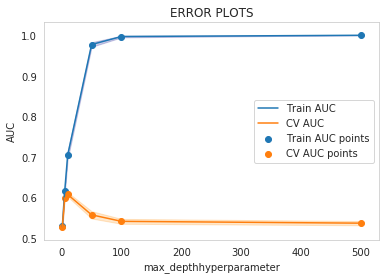

In [197]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#tuned hyper parameters 
parameters_depth = {'max_depth':[1, 5, 10, 50, 100, 500]}
parameters_depth_plot  = [i  for i in parameters_depth['max_depth']]

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced')

#gridsearchcv
grid_search = GridSearchCV(dt_classifier, parameters_depth,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search.fit(X_tra, y_train)    #gridsearch cv fit on train data

print(grid_search.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search.cv_results_['mean_train_score']
train_auc_std= grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score'] 
cv_auc_std= grid_search.cv_results_['std_test_score']

plt.plot(parameters_depth_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_depth_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_depth_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_depth_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depthhyperparameter")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at maxdepth=500 and underfit at max_depth = [0,1,2] 
* so we can choose best max_depth value = 15.

### 1. finding right parameter 'min_samples_split' using gridsearchcv method

**max_depth = 15**

{'min_samples_split': 500}


Text(0.5, 1.0, 'ERROR PLOTS')

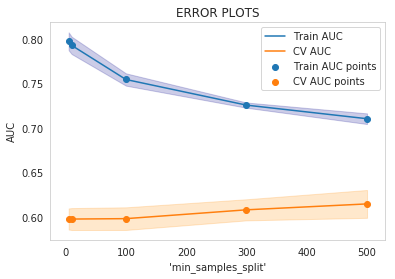

In [198]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#tuned hyper parameters   'min_samples_split'
parameters_min_samples_split = {'min_samples_split': [5, 10, 100,300, 500]}
parameters_min_samplsplt_plot  = [i  for i in parameters_min_samples_split['min_samples_split']]  #for easy to plot on x-axis

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=15, class_weight='balanced') # critertiongini impurity #max_depth - 15 

#gridsearchcv
grid_search = GridSearchCV(dt_classifier,parameters_min_samples_split,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search.fit(X_tra, y_train)    #gridsearch cv fit on train data

print(grid_search.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search.cv_results_['mean_train_score']
train_auc_std= grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score'] 
cv_auc_std= grid_search.cv_results_['std_test_score']

plt.plot(parameters_min_samplsplt_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_min_samplsplt_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_min_samplsplt_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_min_samplsplt_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("'min_samples_split'")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at min_sample_split=[0,1,2,....10] 
* we can choose best'min_samples_split' = 400.

## Now we can observe how our  best 'max_depth' and 'min_sample_split' hyper  parameter values perform on Train AUROC and Test AUROC curves

In [199]:
#according to the above two error plots
best_max_depth = 15
best_min_sample_split= 400

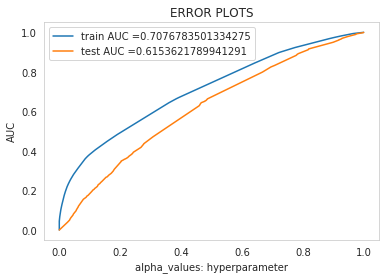

In [200]:
#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=15,min_samples_split=400,class_weight='balanced')

dt_classifier.fit(X_tra, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p 
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,dt_classifier.predict_proba(X_tra)[:,1] )
test_fpr,test_tpr,thresholds = roc_curve(y_test, dt_classifier.predict_proba(X_tes)[:,1]) 
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.grid()
plt.xlabel("alpha_values: hyperparameter") 
plt.ylabel("AUC") 
plt.title("ERROR PLOTS") 
plt.show()      

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.72 and AUC on test data = 0.61


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 6022  1404]
 [21568 20047]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 3782  1677]
 [16201 14392]]


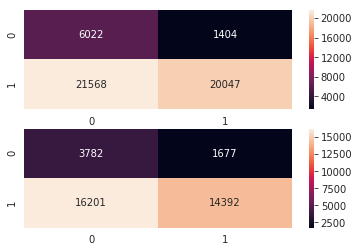

In [201]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig=plt.figure(1)
a = fig.add_subplot(211)
print("Train data confusion matrix") 
a = confusion_matrix(y_train,  dt_classifier.predict(X_tra))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True,fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test, dt_classifier.predict(X_tes))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True,fmt='g')    #annot = True rectanguler dataset

plt.show()
 

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data confusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  20047 true positive values,21568 fpr values,6022 tnr values,1404 fnr values 
* in test confusion matrix we have  14392 true positive values,16201 fpr values,3782 tnr values,1677 fnr values 

## Plot the world cloud for essay text(false positive points)

In [202]:
#pre processed essay text
essay_text= X_train['preproccessed_essay_text']
print("shape of the essay_data:",essay_text.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tra).shape)

shape of the essay_data: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [204]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending actual values and predicted  class label values to the dataframe
df ['actual_values'] = y_train
df ['predicted_values'] = dt_classifier.predict(X_tra)
df.head(3)

,preproccessed_essay_text,actual_values,predicted_values
92963,our school is in the center of start up compan...,1,1
83376,my students come from military families they m...,1,0
97300,i teach 5th grade in a low income school distr...,1,0


**selecting false positive points**

In [205]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp = df [(df['actual_values']==0) & (df['predicted_values']==1)]

print("dataframe shape:",df_fp .shape)

df_fp .head(4)

dataframe shape: (1404, 3)


,preproccessed_essay_text,actual_values,predicted_values
25051,my students are participants in the national a...,0,1
26274,students in our community are eager learners a...,0,1
82340,the students in my class come from low income ...,0,1
32370,my class is very diverse i have a group of stu...,0,1


len of false positive essay_text: 2043477


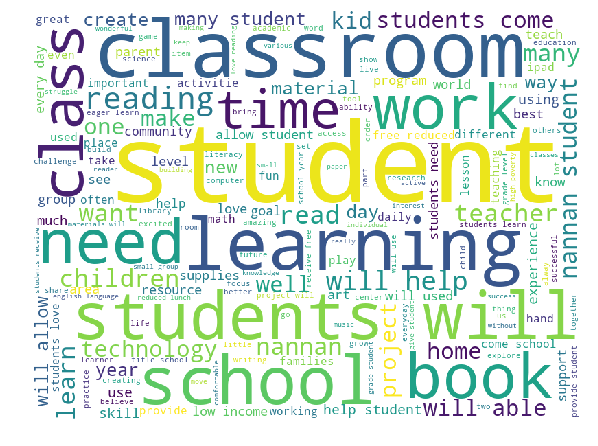

In [206]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_fp.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of false positive essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

**observation:**
* the above words are mostly often repeated words in essay text(false positive points)

## plot the box plot of fals epositiv points of price values

In [208]:
#pre processed essay text
price_data1= X_train['price']
print("shape of the pricedata:",price_data1.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tra).shape)

shape of the pricedata: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [209]:
#constructing dataframe with price data
df1 = pd.DataFrame(price_data1)

#appending actual values and predicted  class label values to the dataframe
df1 ['actual_values'] = y_train
df1 ['predicted_values'] = dt_classifier.predict(X_tra)
df1.head(3)

,price,actual_values,predicted_values
92963,129.90,1,1
83376,8.24,1,0
97300,6.00,1,0


### select the price data points where  false positive points  y==0 and pred_y == 1

In [210]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_price = df1 [(df1['actual_values']==0) & (df1['predicted_values']==1)]

print("dataframe shape:",df_fp_price .shape)

df_fp_price .head(4)

dataframe shape: (1404, 3)


,price,actual_values,predicted_values
25051,12.40,0,1
26274,228.92,0,1
82340,169.02,0,1
32370,201.96,0,1


### plot the box pot of price data

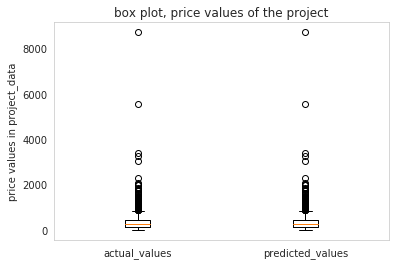

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_price[df_fp_price['predicted_values']==1]['price']  #all predicted  
prd_vls = prd_vls.values

act_vls = df_fp_price[df_fp_price['actual_values']==0]['price']  #all actual price values 
act_vls = act_vls.values


plt.boxplot([act_vls, prd_vls])
plt.title('box plot, price values of the project')
plt.xticks([1,2],('actual_values','predicted_values'))
plt.ylabel('price values in project_data')
plt.grid()
plt.show()

observation: actual values and predicted values for price values  are mostly in range 0 to 300 price values 

### plot the pdf of techer previous posted projects

In [214]:
#pre processed essay text
prvs_prjcts= X_train['teacher_number_of_previously_posted_projects']

print("shape of the teacher_number_of_previously_posted_projects:",prvs_prjcts.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tra).shape)

shape of the teacher_number_of_previously_posted_projects: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [215]:
#constructing dataframe with previous posted projects data
df2 = pd.DataFrame(prvs_prjcts)

#appending actual values and predicted  class label values to the dataframe
df2 ['actual_values'] = y_train
df2 ['predicted_values'] = dt_classifier.predict(X_tra)
df2.head(3)

,teacher_number_of_previously_posted_projects,actual_values,predicted_values
92963,4,1,1
83376,0,1,0
97300,2,1,0


### select the price data points where  false positive points  y==0 and pred_y == 1

In [216]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_prvsprjcts = df2 [(df2['actual_values']==0) & (df2['predicted_values']==1)]

print("dataframe shape:",df_fp_prvsprjcts .shape)

df_fp_prvsprjcts .head(4)

dataframe shape: (1404, 3)


,teacher_number_of_previously_posted_projects,actual_values,predicted_values
25051,0,0,1
26274,0,0,1
82340,4,0,1
32370,2,0,1


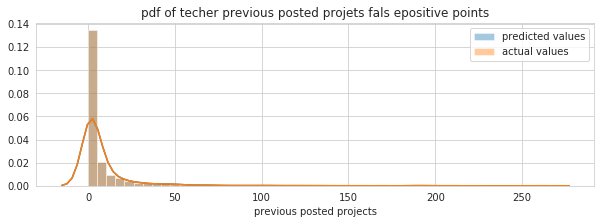

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['predicted_values']==1]['teacher_number_of_previously_posted_projects']
prd_vls = prd_vls.values

act_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['actual_values']==0]['teacher_number_of_previously_posted_projects']
act_vls = act_vls.values

plt.figure(figsize=(10,3))
sns.distplot(prd_vls, hist=True, label="predicted values")
sns.distplot(act_vls, hist=True, label="actual values")
plt.title('pdf of techer previous posted projets fals epositive points')
plt.xlabel('previous posted projects')
plt.legend()
plt.show()

**observation:**
    * the previous posted projects are  mostly in range 0 to 10 of false positive points 

 #  <font color='green'>Applying Decision Tree on set2</font>

# 6.Creating (SET2):
# <font color='green'> data matix with all categorical, all numerical,essay(TFIDF) and title(TFIDF)</font>

In [224]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_tfidf,X_train_title_tfidf, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr1 = hstack((X_cv_essay_tfidf,X_cv_title_tfidf,X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te1 = hstack((X_test_essay_tfidf,X_test_title_tfidf, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set1 Data matrix:")
print(X_tr1.shape, y_train.shape)
print(X_cr1.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)

************************************************************
Final set1 Data matrix:
(49041, 9832) (49041,)
(24155, 9832) (24155,)
(36052, 9832) (36052,)


**we don't ned to do standardizing data in Decision Tree classifier because it impacat on  caluculate the Information gain for every feature**


### applying Decision Tree

### 1. finding right parameter max_depth using gridsearchcv method

{'max_depth': 10}


Text(0.5, 1.0, 'ERROR PLOTS')

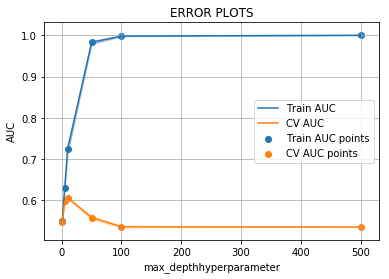

In [82]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#tuned hyper parameters 
parameters_depth = {'max_depth':[1, 5, 10, 50, 100, 500]}
parameters_depth_plot  = [i  for i in parameters_depth['max_depth']]

#classifier 
dt_classifier2 = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced')

#gridsearchcv
grid_search1 = GridSearchCV(dt_classifier, parameters_depth,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search1.fit(X_tr1, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(parameters_depth_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_depth_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_depth_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_depth_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depthhyperparameter")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at maxdepth=500 and underfit at max_depth = [0,1,2] 
* so we can choose best max_depth value = 20.

### 1. finding right parameter 'min_samples_split' using gridsearchcv method

{'min_samples_split': 500}


Text(0.5, 1.0, 'ERROR PLOTS')

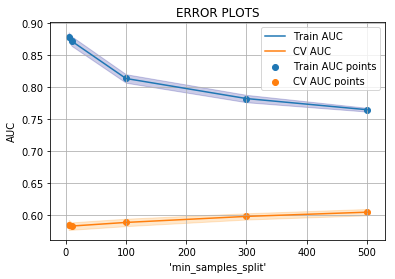

In [83]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#tuned hyper parameters   'min_samples_split'
parameters_min_samples_split = {'min_samples_split': [5, 10, 100,300, 500]}
parameters_min_samplsplt_plot  = [i  for i in parameters_min_samples_split['min_samples_split']]  #for easy to plot on x-axis

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=20, class_weight='balanced')

#gridsearchcv
grid_search1 = GridSearchCV(dt_classifier,parameters_min_samples_split,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search1.fit(X_tr1, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(parameters_min_samplsplt_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_min_samplsplt_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_min_samplsplt_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_min_samplsplt_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("'min_samples_split'")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at min_sample_split=[0,1,2,....10] 
* we can choose best'min_samples_split' = 400

## Now we can observe how our  best 'max_depth' and 'min_sample_split' hyper  parameter values perform on Train AUROC and Test AUROC curves

In [84]:
#according to the above two error plots
best_mx_depth = 20
best_min_sample_split= 400

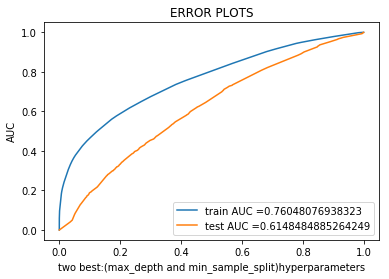

In [85]:
#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=20,min_samples_split=400,class_weight='balanced')

dt_classifier.fit(X_tr1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p 
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,dt_classifier.predict_proba(X_tr1)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test, dt_classifier.predict_proba(X_te1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and min_sample_split)hyperparameters")
plt.ylabel("AUC") 
plt.title("ERROR PLOTS") 
plt.show()      

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.77 and AUC on test data = 0.69


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 6030  1396]
 [17591 24024]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 3378  2081]
 [13853 16740]]


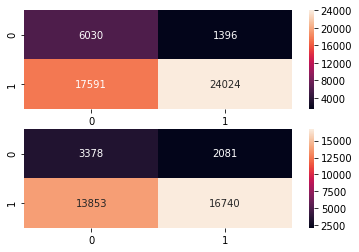

In [86]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig=plt.figure(1)
a = fig.add_subplot(211)
print("Train data confusion matrix") 
a = confusion_matrix(y_train,  dt_classifier.predict(X_tr1))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True,fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test, dt_classifier.predict(X_te1))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True,fmt='g')    #annot = True rectanguler dataset

plt.show()
 

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  24024 true positive values,17591 fpr values, 6030  tnr values,1396 fnr values 
* in test confusion matrix we have  16740 true positive values,13853 fpr values, 3378 tnr values, 2081 fnr values 

## Plot the world cloud for essay text(false positive points)

In [89]:
#pre processed essay text
essay_text= X_train['preproccessed_essay_text']

In [90]:

print("shape of the essay_data:",essay_text.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr1).shape)

shape of the essay_data: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [91]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending actual values and predicted  class label values to the dataframe
df ['actual_values'] = y_train
df ['predicted_values'] = dt_classifier.predict(X_tr1)
df.head(3)

,preproccessed_essay_text,actual_values,predicted_values
92963,our school is in the center of start up compan...,1,1
83376,my students come from military families they m...,1,0
97300,i teach 5th grade in a low income school distr...,1,0


### select the essay text data points where  false positive points  y==0 and pred_y == 1

In [97]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp = df [(df['actual_values']==0) & (df['predicted_values']==1)]

print("dataframe shape:",df_fp .shape)

df_fp .head(4)

dataframe shape: (1396, 3)


,preproccessed_essay_text,actual_values,predicted_values
16536,my goal as an instructor is to be a proactive ...,0,1
103208,my students are hard working and committed to ...,0,1
26274,students in our community are eager learners a...,0,1
82340,the students in my class come from low income ...,0,1


### plot the most often repeat words in false positive essay text using world clod

len of false positive essay_text: 2138121


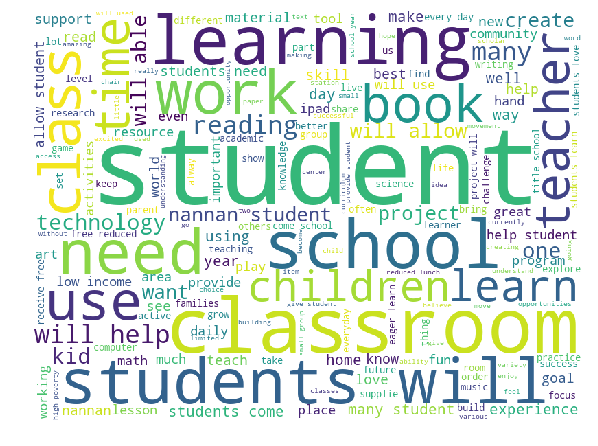

In [108]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_fp.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of false positive essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

**observation:**
* the above words are mostly often repeated words in essay text(false positive points)

## plot the box plot of fals epositiv points of price values

In [122]:
#pre processed essay text
price_data1= X_train['price']

In [125]:
print("shape of the pricedata:",price_data1.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr1).shape)

shape of the pricedata: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [127]:
#constructing dataframe with price data
df1 = pd.DataFrame(price_data1)

#appending actual values and predicted  class label values to the dataframe
df1 ['actual_values'] = y_train
df1 ['predicted_values'] = dt_classifier.predict(X_tr1)
df1.head(3)

,price,actual_values,predicted_values
92963,129.90,1,1
83376,8.24,1,0
97300,6.00,1,0


### select the price data points where  false positive points  y==0 and pred_y == 1

In [128]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_price = df1 [(df1['actual_values']==0) & (df1['predicted_values']==1)]

print("dataframe shape:",df_fp_price .shape)

df_fp_price .head(4)

dataframe shape: (1396, 3)


,price,actual_values,predicted_values
16536,68.86,0,1
103208,282.56,0,1
26274,228.92,0,1
82340,169.02,0,1


### plot the box pot of price data

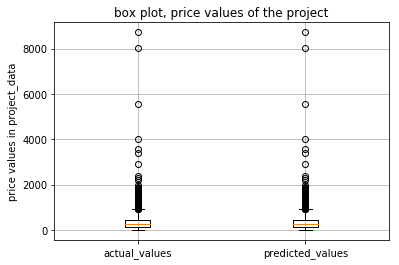

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_price[df_fp_price['predicted_values']==1]['price']  #all predicted  
prd_vls = prd_vls.values

act_vls = df_fp_price[df_fp_price['actual_values']==0]['price']  #all actual price values 
act_vls = act_vls.values

plt.boxplot([act_vls, prd_vls])
plt.title('box plot, price values of the project')
plt.xticks([1,2],('actual_values','predicted_values'))
plt.ylabel('price values in project_data')
plt.grid()
plt.show()

observation: actual values and predicted values for price values  are mostly in range 0 to 300 price values 

### plot the pdf of techer previous posted projects

In [141]:
#pre processed essay text
prvs_prjcts= X_train['teacher_number_of_previously_posted_projects']

In [142]:
print("shape of the teacher_number_of_previously_posted_projects:",prvs_prjcts.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr1).shape)

shape of the teacher_number_of_previously_posted_projects: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [143]:
#constructing dataframe with previous posted projects data
df2 = pd.DataFrame(prvs_prjcts)

#appending actual values and predicted  class label values to the dataframe
df2 ['actual_values'] = y_train
df2 ['predicted_values'] = dt_classifier.predict(X_tr1)
df2.head(3)

,teacher_number_of_previously_posted_projects,actual_values,predicted_values
92963,4,1,1
83376,0,1,0
97300,2,1,0


### select the price data points where  false positive points  y==0 and pred_y == 1

In [144]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_prvsprjcts = df2 [(df2['actual_values']==0) & (df2['predicted_values']==1)]

print("dataframe shape:",df_fp_prvsprjcts .shape)

df_fp_prvsprjcts .head(4)

dataframe shape: (1396, 3)


,teacher_number_of_previously_posted_projects,actual_values,predicted_values
16536,2,0,1
103208,2,0,1
26274,0,0,1
82340,4,0,1


### plot the pdf

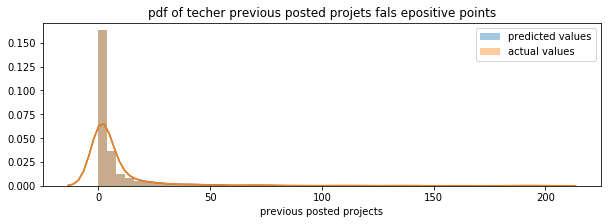

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['predicted_values']==1]['teacher_number_of_previously_posted_projects']
prd_vls = prd_vls.values

act_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['actual_values']==0]['teacher_number_of_previously_posted_projects']
act_vls = act_vls.values

plt.figure(figsize=(10,3))
sns.distplot(prd_vls, hist=True, label="predicted values")
sns.distplot(act_vls, hist=True, label="actual values")
plt.title('pdf of techer previous posted projets fals epositive points')
plt.xlabel('previous posted projects')
plt.legend()
plt.show()

**observation:**
    * the previous posted projects are  mostly in range 0 to 10 of false positive points 

# 5.Creating (SET3):
# <font color='blue'> data matix with all categorical, all numerical,essay(avgw2v) and title(avgw2v)</font>

In [152]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr3 = hstack((X_train_essay_avgw2v,X_train_title_avgw2v, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr3 = hstack((X_cv_essay_avgw2v,X_cv_title_avgw2v,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te3 = hstack((X_test_essay_avgw2v,X_test_title_avgw2v, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set3 Data matrix:")
print(X_tr3.shape, y_train.shape)
print(X_cr3.shape, y_cv.shape)
print(X_te3.shape, y_test.shape)

************************************************************
Final set3 Data matrix:
(49041, 203) (49041,)
(24155, 203) (24155,)
(36052, 203) (36052,)


**we don't ned to do standardizing data in Decision Tree classifier because it impacat on  caluculate the Information gain for every feature**


### applying Decision Tree

### 1. finding right parameter max_depth using gridsearchcv method

{'max_depth': 5}


Text(0.5, 1.0, 'ERROR PLOTS')

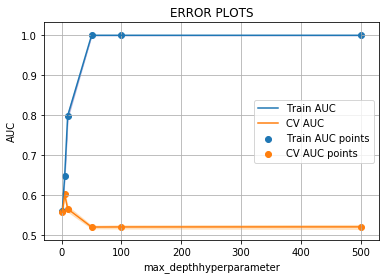

In [153]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#tuned hyper parameters 
parameters_depth = {'max_depth':[1, 5, 10, 50, 100, 500]}
parameters_depth_plot  = [i  for i in parameters_depth['max_depth']]

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced')

#gridsearchcv
grid_search = GridSearchCV(dt_classifier, parameters_depth,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr3, y_train)    #gridsearch cv fit on train data

print(grid_search.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search.cv_results_['mean_train_score']
train_auc_std= grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score'] 
cv_auc_std= grid_search.cv_results_['std_test_score']

plt.plot(parameters_depth_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_depth_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_depth_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_depth_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depthhyperparameter")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at maxdepth=500 and underfit at max_depth = [0,1,2] 
* so we can choose best max_depth value = 5

### 1. finding right parameter 'min_samples_split' using gridsearchcv method

{'min_samples_split': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

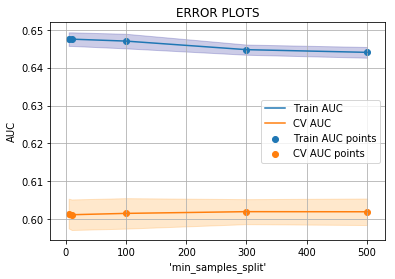

In [154]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#tuned hyper parameters   'min_samples_split'
parameters_min_samples_split = {'min_samples_split': [5, 10, 100,300, 500]}
parameters_min_samplsplt_plot  = [i  for i in parameters_min_samples_split['min_samples_split']]  #for easy to plot on x-axis

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=5, class_weight='balanced')

#gridsearchcv
grid_search = GridSearchCV(dt_classifier,parameters_min_samples_split,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr3, y_train)    #gridsearch cv fit on train data

print(grid_search.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search.cv_results_['mean_train_score']
train_auc_std= grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score'] 
cv_auc_std= grid_search.cv_results_['std_test_score']

plt.plot(parameters_min_samplsplt_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_min_samplsplt_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_min_samplsplt_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_min_samplsplt_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("'min_samples_split'")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at min_sample_split=[0,1,2,....10] 
* we can choose best'min_samples_split' = 300

## Now we can observe how our  best 'max_depth' and 'min_sample_split' hyper  parameter values perform on Train AUROC and Test AUROC curves

In [155]:
#according to the above two error plots
best_mx_depth = 5
best_min_sample_split= 300

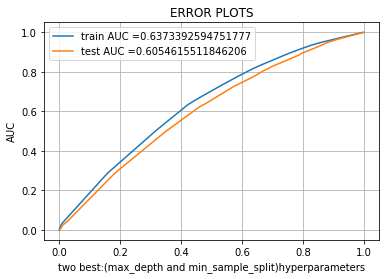

In [159]:
#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=5,min_samples_split=300,class_weight='balanced')

dt_classifier.fit(X_tr3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p 
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,dt_classifier.predict_proba(X_tr3)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test, dt_classifier.predict_proba(X_te3)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and min_sample_split)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()      

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.63 and AUC on test data = 0.59


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 4291  3135]
 [15248 26367]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 2925  2534]
 [11443 19150]]


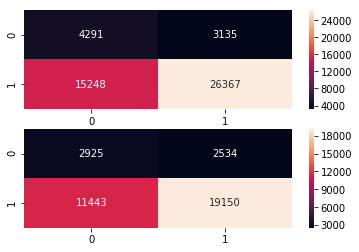

In [160]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html


fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train,dt_classifier.predict(X_tr3))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True,fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,dt_classifier.predict(X_te3))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True,fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  26367 true positive values, 15248 fpr values,4291 tnr values,3135 fnr values 
* in test confusion matrix we have  19150 true positive values,11443 fpr values, 2925 tnr values,2534 fnr values 

## Plot the world cloud for essay text(false positive points)

In [162]:
#pre processed essay text
essay_text= X_train['preproccessed_essay_text']
print("shape of the essay_data:",essay_text.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr3).shape)

shape of the essay_data: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [163]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending actual values and predicted  class label values to the dataframe
df ['actual_values'] = y_train
df ['predicted_values'] = dt_classifier.predict(X_tr3)
df.head(3)

,preproccessed_essay_text,actual_values,predicted_values
92963,our school is in the center of start up compan...,1,1
83376,my students come from military families they m...,1,0
97300,i teach 5th grade in a low income school distr...,1,1


In [164]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp = df [(df['actual_values']==0) & (df['predicted_values']==1)]

print("dataframe shape:",df_fp .shape)

df_fp .head(4)

dataframe shape: (3135, 3)


,preproccessed_essay_text,actual_values,predicted_values
34877,my students are happy and energetic children w...,0,1
16536,my goal as an instructor is to be a proactive ...,0,1
82340,the students in my class come from low income ...,0,1
7013,as a teacher in a low income mostly high pover...,0,1


len of false positive essay_text: 4546153


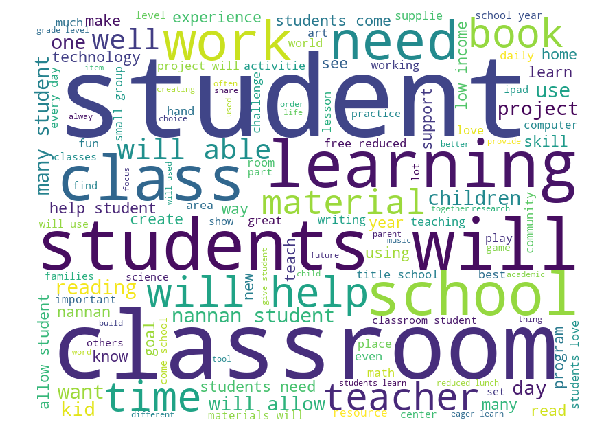

In [165]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_fp.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of false positive essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

the above words are mostly often occured words in essay text

## plot the box plot of fals epositiv points of price values

In [167]:
#pre processed essay text
price_data1= X_train['price']
print("shape of the pricedata:",price_data1.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr3).shape)

#constructing dataframe with price data
df1 = pd.DataFrame(price_data1)

#appending actual values and predicted  class label values to the dataframe
df1 ['actual_values'] = y_train
df1 ['predicted_values'] = dt_classifier.predict(X_tr3)
df1.head(3)

shape of the pricedata: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


,price,actual_values,predicted_values
92963,129.90,1,1
83376,8.24,1,0
97300,6.00,1,1


### select the price data points where  false positive points  y==0 and pred_y == 1

In [168]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_price = df1 [(df1['actual_values']==0) & (df1['predicted_values']==1)]

print("dataframe shape:",df_fp_price .shape)

df_fp_price .head(4)

dataframe shape: (3135, 3)


,price,actual_values,predicted_values
34877,259.93,0,1
16536,68.86,0,1
82340,169.02,0,1
7013,232.80,0,1


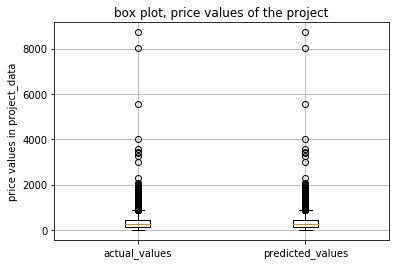

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_price[df_fp_price['predicted_values']==1]['price']
prd_vls = prd_vls.values

act_vls = df_fp_price[df_fp_price['actual_values']==0]['price']
act_vls = act_vls.values

plt.boxplot([act_vls, prd_vls])
plt.title('box plot, price values of the project')
plt.xticks([1,2],('actual_values','predicted_values'))
plt.ylabel('price values in project_data')
plt.grid()
plt.show()

observation: actual values and predicted values for price values  are mostly in range 0 to 400 price values 

### plot the pdf of techer previous posted projects

In [171]:
#pre processed essay text
prvs_prjcts= X_train['teacher_number_of_previously_posted_projects']
print("shape of the teacher_number_of_previously_posted_projects:",prvs_prjcts.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr3).shape)
#constructing dataframe with previous posted projects data
df2 = pd.DataFrame(prvs_prjcts)

#appending actual values and predicted  class label values to the dataframe
df2 ['actual_values'] = y_train
df2 ['predicted_values'] = dt_classifier.predict(X_tr3)
df2.head(3)

shape of the teacher_number_of_previously_posted_projects: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


,teacher_number_of_previously_posted_projects,actual_values,predicted_values
92963,4,1,1
83376,0,1,0
97300,2,1,1


### select the price data points where  false positive points  y==0 and pred_y == 1

In [172]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_prvsprjcts = df2 [(df2['actual_values']==0) & (df2['predicted_values']==1)]

print("dataframe shape:",df_fp_prvsprjcts .shape)

df_fp_prvsprjcts .head(4)

dataframe shape: (3135, 3)


,teacher_number_of_previously_posted_projects,actual_values,predicted_values
34877,13,0,1
16536,2,0,1
82340,4,0,1
7013,0,0,1


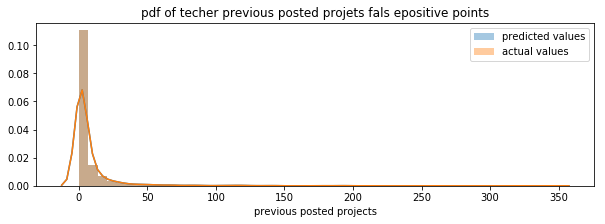

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['predicted_values']==1]['teacher_number_of_previously_posted_projects']
prd_vls = prd_vls.values

act_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['actual_values']==0]['teacher_number_of_previously_posted_projects']
act_vls = act_vls.values

plt.figure(figsize=(10,3))
sns.distplot(prd_vls, hist=True, label="predicted values")
sns.distplot(act_vls, hist=True, label="actual values")
plt.title('pdf of techer previous posted projets fals epositive points')
plt.xlabel('previous posted projects')
plt.legend()
plt.show()

**observation:**
    * the previous posted projects are  mostly in range 0 to 10 of false positive points 

 #  <font color='green'>Applying Decision Tree on set4</font>

# 8.Creating (SET4):
# <font color='green'> data matix with all categorical, all numerical,essay(TFIDF-W2V) and title(TFIDF-W2V)</font>

In [175]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr4 = hstack((X_train_essay_tfidfw2v,X_train_title_tfidfw2v, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr4 = hstack((X_cv_essay_tfidfw2v,X_cv_title_tfidfw2v,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te4 = hstack((X_test_essay_tfidfw2v,X_test_title_tfidfw2v, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set4 Data matrix:")
print(X_tr4.shape, y_train.shape)
print(X_cr4.shape, y_cv.shape)
print(X_te4.shape, y_test.shape)


************************************************************
Final set4 Data matrix:
(49041, 203) (49041,)
(24155, 203) (24155,)
(36052, 203) (36052,)


**we don't ned to do standardizing data in Decision Tree classifier because it impacat on  caluculate the Information gain for every feature**


### applying Decision Tree

### 1. finding right parameter max_depth using gridsearchcv method

{'max_depth': 5}


Text(0.5, 1.0, 'ERROR PLOTS')

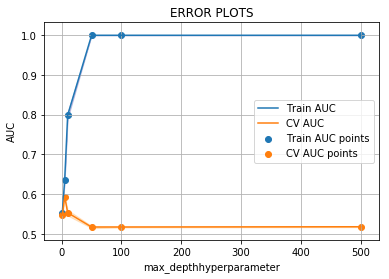

In [176]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#tuned hyper parameters 
parameters_depth = {'max_depth':[1, 5, 10, 50, 100, 500]}
parameters_depth_plot  = [i  for i in parameters_depth['max_depth']]

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced')

#gridsearchcv
grid_search = GridSearchCV(dt_classifier, parameters_depth,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr4, y_train)    #gridsearch cv fit on train data

print(grid_search.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search.cv_results_['mean_train_score']
train_auc_std= grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score'] 
cv_auc_std= grid_search.cv_results_['std_test_score']

plt.plot(parameters_depth_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_depth_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_depth_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_depth_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_depth_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depthhyperparameter")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at maxdepth=500 and underfit at max_depth = [0,1,2] 
* so we can choose best max_depth value = 10

### 1. finding right parameter 'min_samples_split' using gridsearchcv method

{'min_samples_split': 500}


Text(0.5, 1.0, 'ERROR PLOTS')

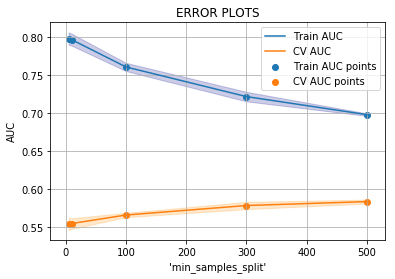

In [177]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#tuned hyper parameters   'min_samples_split'
parameters_min_samples_split = {'min_samples_split': [5, 10, 100,300, 500]}
parameters_min_samplsplt_plot  = [i  for i in parameters_min_samples_split['min_samples_split']]  #for easy to plot on x-axis

#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=10, class_weight='balanced')

#gridsearchcv
grid_search = GridSearchCV(dt_classifier,parameters_min_samples_split,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search.fit(X_tr4, y_train)    #gridsearch cv fit on train data

print(grid_search.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search.cv_results_['mean_train_score']
train_auc_std= grid_search.cv_results_['std_train_score']
cv_auc = grid_search.cv_results_['mean_test_score'] 
cv_auc_std= grid_search.cv_results_['std_test_score']

plt.plot(parameters_min_samplsplt_plot, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters_min_samplsplt_plot, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters_min_samplsplt_plot,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters_min_samplsplt_plot, train_auc, label='Train AUC points')
plt.scatter(parameters_min_samplsplt_plot, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("'min_samples_split'")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation**
* accordung to the above plot train auc and cv auc are Overfit at min_sample_split=[0,1,2,....10] 
* we can choose best'min_samples_split' = 400

## Now we can observe how our  best 'max_depth' and 'min_sample_split' hyper  parameter values perform on Train AUROC and Test AUROC curves

In [178]:
#according to the above two error plots
best_mx_depth = 10
best_min_sample_split= 400

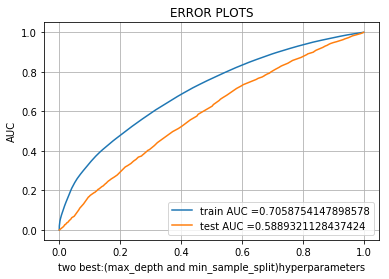

In [179]:
#classifier 
dt_classifier = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=10,min_samples_split=400,class_weight='balanced')

dt_classifier.fit(X_tr4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p 
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,dt_classifier.predict_proba(X_tr4)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test, dt_classifier.predict_proba(X_te4)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and min_sample_split)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()      

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.69 and AUC on test data = 0.58


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 5076  2350]
 [16335 25280]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 2973  2486]
 [12738 17855]]


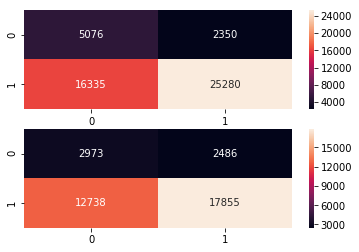

In [181]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html


fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, dt_classifier.predict(X_tr4))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,dt_classifier.predict(X_te4))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have 25280 true positive values, 16335 fpr values, 5076 tnr values,2350 fnr values 
* in test confusion matrix we have  17855 true positive values,12738 fpr values,2973 tnr values,2486 fnr values 

## Plot the world cloud for essay text(false positive points)

In [182]:
#pre processed essay text
essay_text= X_train['preproccessed_essay_text']
print("shape of the essay_data:",essay_text.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr4).shape)

shape of the essay_data: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


In [184]:
#constructing dataframe with essay data
df = pd.DataFrame(essay_text)

#appending actual values and predicted  class label values to the dataframe
df ['actual_values'] = y_train
df ['predicted_values'] = dt_classifier.predict(X_tr4)
df.head(3)

,preproccessed_essay_text,actual_values,predicted_values
92963,our school is in the center of start up compan...,1,1
83376,my students come from military families they m...,1,0
97300,i teach 5th grade in a low income school distr...,1,1


In [185]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp = df [(df['actual_values']==0) & (df['predicted_values']==1)]

print("dataframe shape:",df_fp .shape)

df_fp .head(4)

dataframe shape: (2350, 3)


,preproccessed_essay_text,actual_values,predicted_values
68413,small in number big in spirit my students are ...,0,1
82340,the students in my class come from low income ...,0,1
7013,as a teacher in a low income mostly high pover...,0,1
588,my students are an amazing group of 60 dual la...,0,1


len of false positive essay_text: 3433386


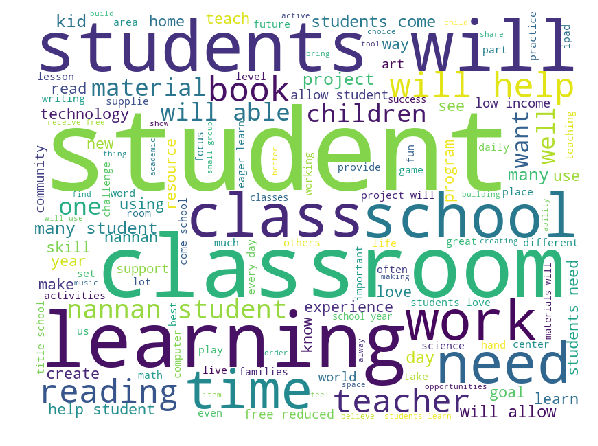

In [186]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

total_words=' '
for i in df_fp.preproccessed_essay_text:
        total_words = total_words+i+' '
        
print("len of false positive essay_text:",len(total_words))
      
wordcloud = WordCloud(width = 800, height = 600, background_color ='white', min_font_size = 10).generate(total_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

the above words are mostly often occured words in essay text

## plot the box plot of false positiv points of price values

In [187]:
#pre processed essay text
price_data1= X_train['price']
print("shape of the pricedata:",price_data1.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr4).shape)

#constructing dataframe with price data
df1 = pd.DataFrame(price_data1)

#appending actual values and predicted  class label values to the dataframe
df1 ['actual_values'] = y_train
df1 ['predicted_values'] = dt_classifier.predict(X_tr4)
df1.head(3)

shape of the pricedata: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


,price,actual_values,predicted_values
92963,129.90,1,1
83376,8.24,1,0
97300,6.00,1,1


In [188]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_price = df1 [(df1['actual_values']==0) & (df1['predicted_values']==1)]

print("dataframe shape:",df_fp_price .shape)

df_fp_price .head(4)

dataframe shape: (2350, 3)


,price,actual_values,predicted_values
68413,52.56,0,1
82340,169.02,0,1
7013,232.80,0,1
588,149.92,0,1


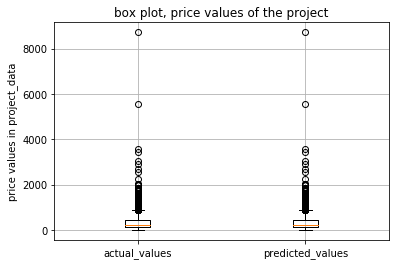

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_price[df_fp_price['predicted_values']==1]['price']
prd_vls = prd_vls.values

act_vls = df_fp_price[df_fp_price['actual_values']==0]['price']
act_vls = act_vls.values

plt.boxplot([act_vls, prd_vls])
plt.title('box plot, price values of the project')
plt.xticks([1,2],('actual_values','predicted_values'))
plt.ylabel('price values in project_data')
plt.grid()
plt.show()

observation: actual values and predicted values for price values  are mostly in range 0 to 300 price values 

### plot the pdf of techer previous posted projects

In [190]:
#pre processed essay text
prvs_prjcts= X_train['teacher_number_of_previously_posted_projects']
print("shape of the teacher_number_of_previously_posted_projects:",prvs_prjcts.shape)
print("shape of actual yi's:",y_train.shape)
print("shape of the predicted yi's:",dt_classifier.predict(X_tr4).shape)
#constructing dataframe with previous posted projects data
df2 = pd.DataFrame(prvs_prjcts)

#appending actual values and predicted  class label values to the dataframe
df2 ['actual_values'] = y_train
df2 ['predicted_values'] = dt_classifier.predict(X_tr4)
df2.head(3)

shape of the teacher_number_of_previously_posted_projects: (49041,)
shape of actual yi's: (49041,)
shape of the predicted yi's: (49041,)


,teacher_number_of_previously_posted_projects,actual_values,predicted_values
92963,4,1,1
83376,0,1,0
97300,2,1,1


In [191]:
#now selection only false positive datapoints  wher y==0 and pred_y == 1
df_fp_prvsprjcts = df2 [(df2['actual_values']==0) & (df2['predicted_values']==1)]

print("dataframe shape:",df_fp_prvsprjcts .shape)

df_fp_prvsprjcts .head(4)

dataframe shape: (2350, 3)


,teacher_number_of_previously_posted_projects,actual_values,predicted_values
68413,0,0,1
82340,4,0,1
7013,0,0,1
588,8,0,1


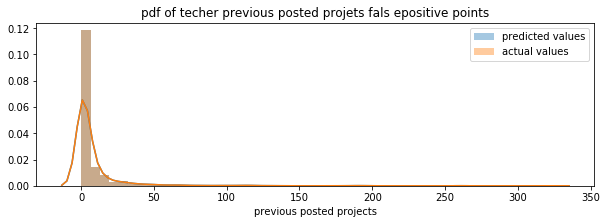

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns


prd_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['predicted_values']==1]['teacher_number_of_previously_posted_projects']
prd_vls = prd_vls.values

act_vls = df_fp_prvsprjcts[df_fp_prvsprjcts['actual_values']==0]['teacher_number_of_previously_posted_projects']
act_vls = act_vls.values

plt.figure(figsize=(10,3))
sns.distplot(prd_vls, hist=True, label="predicted values")
sns.distplot(act_vls, hist=True, label="actual values")
plt.title('pdf of techer previous posted projets fals epositive points')
plt.xlabel('previous posted projects')
plt.legend()
plt.show()

**observation:**
    * the previous posted projects are  mostly in range 0 to 10 of false positive points 

# Selecting best 5k features from features of Set2  and perform logistic regression 

### <font color='green'> Creating (SET2)  with all categorical, all numerical,essay(TFIDF) and title(TFIDF)</font>

In [271]:
#slecting top 5k features
X_tr_top5000=X_tr1.tocsc()[:,:5000]
X_cr_top5000 = X_cr1.tocsc()[:,:5000]
X_te_top5000 = X_te1.tocsc()[:,:5000]

print("*"*60)
print("after selecting 5k datapoints:")
print(X_tr_top5000.shape, y_train.shape)
print(X_cr_top5000.shape, y_cv.shape)
print(X_te_top5000.shape, y_test.shape)

************************************************************
after selecting 5k datapoints:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


**standardization of train,cv and test data with mean = False**

In [272]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

#standardization train data
strd1 = StandardScaler(with_mean=False)
strd1.fit(X_tr_top5000)

strd_tfidftrain_data = strd1.transform(X_tr_top5000)
print(strd_tfidftrain_data.shape)
#standardization crosas validationdata
strd_tfidfcrv_data = strd1.transform(X_cr_top5000)
print(strd_tfidfcrv_data.shape)
#standardization test data
strd_tfidftest_data=strd1.transform(X_te_top5000)
print(strd_tfidftest_data.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


## <font color='green'>best parameter tuning using Grid search technique</font>

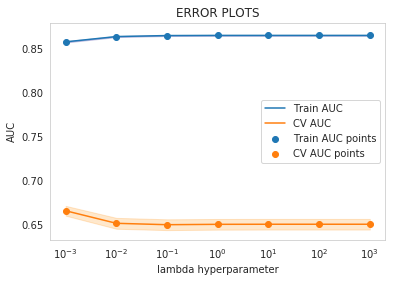

In [273]:
#logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
classifier =  LogisticRegression(penalty ='l2', class_weight= 'balanced', max_iter=200)  #selecting l2 regulerization

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]
gridsrch_parameters1  = [i  for i in gridsrch_parameters[0]['C']]   #(tuned parameters) : easy to read on x axis

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grdsrch = GridSearchCV(classifier,gridsrch_parameters, scoring = 'roc_auc', cv=5,return_train_score=True)    #estimator is logistic regression
grdsrch.fit(strd_tfidftrain_data, y_train)         #grid search cv applying  on  standerdized train data

train_auc= grdsrch.cv_results_['mean_train_score']
train_auc_std= grdsrch.cv_results_['std_train_score']
cv_auc = grdsrch.cv_results_['mean_test_score'] 
cv_auc_std= grdsrch.cv_results_['std_test_score']

plt.plot(gridsrch_parameters1, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(gridsrch_parameters1, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(gridsrch_parameters1, train_auc, label='Train AUC points')
plt.scatter(gridsrch_parameters1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [274]:
#according to the above for auc plot result result we can choose 0.001 is our best 'C' as hyper parameter

best_c = 0.001

### Now we can observe how our  best'c' hyper  parameter value perform on Train AUROC and Test AUROC curves

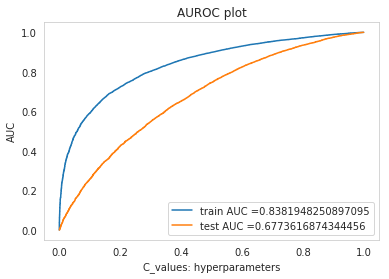

In [277]:
classifier = LogisticRegression(penalty='l2', class_weight= 'balanced',C=best_c)   ## c = 0.001 our selected  best hyper prameter value 
classifier.fit(strd_tfidftrain_data, y_train)   #classifier fit on the tfidf train data
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p 
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,classifier.predict_proba(strd_tfidftrain_data)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,classifier.predict_proba(strd_tfidftest_data)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.xlabel("C_values: hyperparameters")
plt.ylabel("AUC")
plt.title("AUROC plot")
plt.grid()
plt.legend()
plt.show()


### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.83 and AUC on test data = 0.67


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 5788  1638]
 [10700 30915]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 2990  2469]
 [ 9063 21530]]


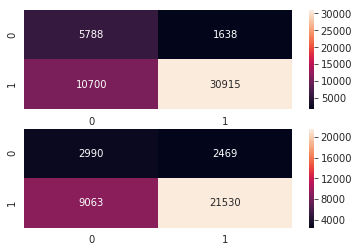

In [278]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html


fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, classifier.predict(strd_tfidftrain_data))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,classifier.predict(strd_tfidftest_data))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  30915 true positive values,10700 fpr values,5788 tnr values,1638 fnr values 
* in test confusion matrix we have  21530 true positive values,9063 fpr values, 2990 tnr values,2469 fnr values 

# Summary(Conclusion):
* we have find best max_depth and min_samples hyper parameters by using grid search method decision tree classifier for      4 sets data.
* we can  observe all AUROC values on plots for each set(se1...set4) then we can choose best 'max_depth' value  is 10  and best min_samples = 400.
* we got best train data auc on set1 dataset. 
* cofusion matrix  gives us clear details about how many true positive points and false positive points,true negetive points and false negetive points for each set data.

# Summary in Tabular form
### all results summarized in the tabular form

In [284]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
a = PrettyTable()
a.field_names = ["data(vectorized features)","Model","best_max_depth","best_min_sample_spli","best'c'", "AUC"]

a.add_row(["set1(all_nmr,ct+essay&tite(BOW))", "Decisiontree",15,400,'-',0.70 ])
a.add_row(["set2(all_nmr,ct+essay&tite(TFIDF)", "Decisiontree",20,400,'-',0.76])
a.add_row(["set3(all_nmr,ct+essay&tite(avgw2v))", "Decisiontree",5,300,'-',0.63 ])
a.add_row(["set4(all_nmr,ct+essay&tite(tfidfw2v))", "Decisiontree",10,400,'-',0.70 ])
a.add_row(["set2(all_nmr,ct+essay&tite(TFIDF)", "logistic_regression",'-','-',0.001,0.83 ])
print(a)

+---------------------------------------+---------------------+----------------+----------------------+---------+------+
|       data(vectorized features)       |        Model        | best_max_depth | best_min_sample_spli | best'c' | AUC  |
+---------------------------------------+---------------------+----------------+----------------------+---------+------+
|    set1(all_nmr,ct+essay&tite(BOW))   |     Decisiontree    |       15       |         400          |    -    | 0.7  |
|   set2(all_nmr,ct+essay&tite(TFIDF)   |     Decisiontree    |       20       |         400          |    -    | 0.76 |
|  set3(all_nmr,ct+essay&tite(avgw2v))  |     Decisiontree    |       5        |         300          |    -    | 0.63 |
| set4(all_nmr,ct+essay&tite(tfidfw2v)) |     Decisiontree    |       10       |         400          |    -    | 0.7  |
|   set2(all_nmr,ct+essay&tite(TFIDF)   | logistic_regression |       -        |          -           |  0.001  | 0.83 |
+-------------------------------